# Computational Biology Seminar
## Project 1: Transcriptomics

In [2]:
import numpy as np
import csv

In [3]:
genes = []
data = []

with open("data/GSE150910_gene-level_count_file.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        
        genes.append(row[0])
        data.append(row[1:])

In [4]:
# first row is sample labels
samples = data[0]
data = data[1:]
genes = genes[1:]

In [5]:
# everything is read in as strings, so we need to cast the data to floats
data = np.array(data).astype(float)

# also cast samples and genes to np array
genes = np.array(genes)
samples = np.array(samples)

In [6]:
# shape checks

print(genes.shape)
print(samples.shape)
print(data.shape)

(18838,)
(288,)
(18838, 288)


In [7]:
labels = []

for i in range(len(samples)):
    tmp = samples[i].split("_")
    labels.append(tmp[0])
    


In [8]:
labels = np.array(labels)


# set(labels)

data = data[:,labels != "chp"]
samples = samples[labels != "chp"]
labels = labels[labels != "chp"]


print(data.shape)
print(samples.shape)
print(labels.shape)


(18838, 206)
(206,)
(206,)


In [9]:
# rough normalization


for j in range(data.shape[1]):
    column_sum = sum(data[:,j])
    
    data[:,j] = data[:,j] / column_sum


# print(data)

In [22]:
# t-test attempt

from scipy.stats import ttest_ind

p_values = []
log2_FCs = []

epsilon = 1e-8  # small constant to avoid division by zero

for i in range(data.shape[0]):
    
    control = data[i, labels == "control"]
    ipf = data[i, labels == "ipf"]

    # perform t-test
    t_statistic, p_value = ttest_ind(control, ipf, equal_var=False)
    p_values.append(p_value)

    # calculate means for each condition
    control_mean = np.mean(control)
    ipf_mean = np.mean(ipf)

    # calculate log2(fold change), adding epsilon to avoid division by 0
    FC = (ipf_mean + epsilon) / (control_mean + epsilon)
    log2_FC = np.log2(FC)
    log2_FCs.append(log2_FC)


    
p_values = np.array(p_values)
log2_FCs = np.array(log2_FCs)


In [21]:
# # differential expression analysis

# from scipy.stats import ks_2samp


# p_values = []
# log2_FCs = []


# for i in range(data.shape[0]):
    
    
#     control = data[i,labels == "control"]
#     ipf = data[i,labels == "ipf"]
    
#     # get p-value
#     ks_statistic, p_value = ks_2samp(control, ipf)
#     p_values.append(p_value)
    
#     control_mean = np.mean(control)
#     if control_mean == 0:
#         control_mean = 0.00000001
#         # to avoid division by 0 error

        
#     ipf_mean = np.mean(ipf)
#     if ipf_mean == 0:
#         ipf_mean = 0.00000001
#         # to avoid division by 0 error
        
        
#     # get log2_FC
#     FC = ipf_mean / control_mean
#     log2_FC = np.log2(FC)
#     log2_FCs.append(log2_FC)
    


In [29]:
p_values_bonf = p_values * len(genes)
# to_keep = (p_values_bonf <= 0.05) & (np.abs(log2_FCs) >= 2)
to_keep = (p_values_bonf <= 0.05) & (np.abs(log2_FCs) >= 1)


sig_genes = genes[to_keep]
sig_log2_FCs = log2_FCs[to_keep]
sig_p_values_bonf = p_values_bonf[to_keep]
sig_data = data[to_keep, :]


print(sig_data.shape)
print(data.shape)



(1153, 206)
(18838, 206)


In [30]:
# print out DEG lists
for i in range(len(sig_genes)):
    if sig_log2_FCs[i] > 0:
        print(sig_genes[i])


        
        
        

CFH
HS3ST1
AOC1
HECW1
KLHL13
CD38
ZMYND10
PRSS22
MEOX1
ABCB4
CRLF1
CACNA1G
USH1C
PROM1
DNAH9
CEACAM7
CD79B
FMO1
ZBTB32
DPEP1
CLCA4
IGF1
ATP1A2
KCNG1
SLAMF7
ARNTL2
HMGB3
EFCAB1
USP2
C6
SOX30
TNC
ADAM28
BARX2
CP
TNFRSF17
EPN3
LTBP1
ENTPD2
FOXC1
CBLN4
CHRDL2
ITIH1
NPFFR2
PKP2
SPAG4
CDH3
GPC1
SPA17
EYA2
BCAS1
COL17A1
NGEF
HES2
ST6GALNAC1
MYO3B
MRVI1
TP63
ST6GAL1
PPP2R2C
CDHR2
WSCD2
ATP12A
FAP
TP73
PTPRH
PIH1D3
IGSF9B
AFP
KCNK2
P2RX5
IGSF9
FAT2
MMP2
GNAO1
PTHLH
TMEM40
SLC4A11
CFAP61
FETUB
DLL3
IL5RA
CCDC80
DAZL
COL9A3
WHRN
EFHC1
DSP
MMP11
DERL3
GGT5
CENPM
RSPH14
RAB36
COCH
SAMD15
ASB2
SERPINA4
CPNE6
NFATC4
HNF4A
SALL4
DOK5
BMP7
SLC17A9
NKAIN4
SPEF1
FERMT1
WFDC2
VSIG1
PIM2
TIMP1
KLHL4
TAF7L
FGF14
HTR2A
CCDC113
FA2H
SLC7A5
RHBDL1
CRYM
SLC6A2
IGDCC4
KCNN4
FCER2
CD79A
CAPS
THEG
SLC5A5
COMP
TMEM59L
RUNDC3B
CFAP69
DLX5
GSDME
PTPRZ1
SFRP4
AGR2
PRUNE2
ASPN
DNM1
CA9
DNAJC12
KRT32
COL1A1
PTGES3L-AARSD1
NRXN2
MDK
POU2AF1
ASIC1
TRPV4
MYL2
RASAL1
GNB3
SLCO1B3
RSPH4A
PACRG
PDE10A
SMOC2
THBS4
CDX1
CNTN3
C

In [27]:
# # print out DEG lists

# for i in range(len(sig_genes)):
#     if sig_log2_FCs[i] > 0:
#         print(sig_genes[i])


output_file = "output/upregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] > 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])


            
            
            
output_file = "output/downregulated_DEGs.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["gene", "p_value", "log2_FC"])

    for i in range(len(sig_genes)):
        if sig_log2_FCs[i] < 0:
            writer.writerow([sig_genes[i], sig_p_values_bonf[i], sig_log2_FCs[i]])





In [31]:
sig_data_log2fc = sig_data.copy()

for i in range(len(sig_genes)):
    
    control_mean =  np.mean(sig_data[i,labels == "control"])
    
    sig_data_log2fc[i,:] = np.log2((sig_data_log2fc[i,:]+0.000001) / (control_mean +0.000001))
    
    
    
    
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


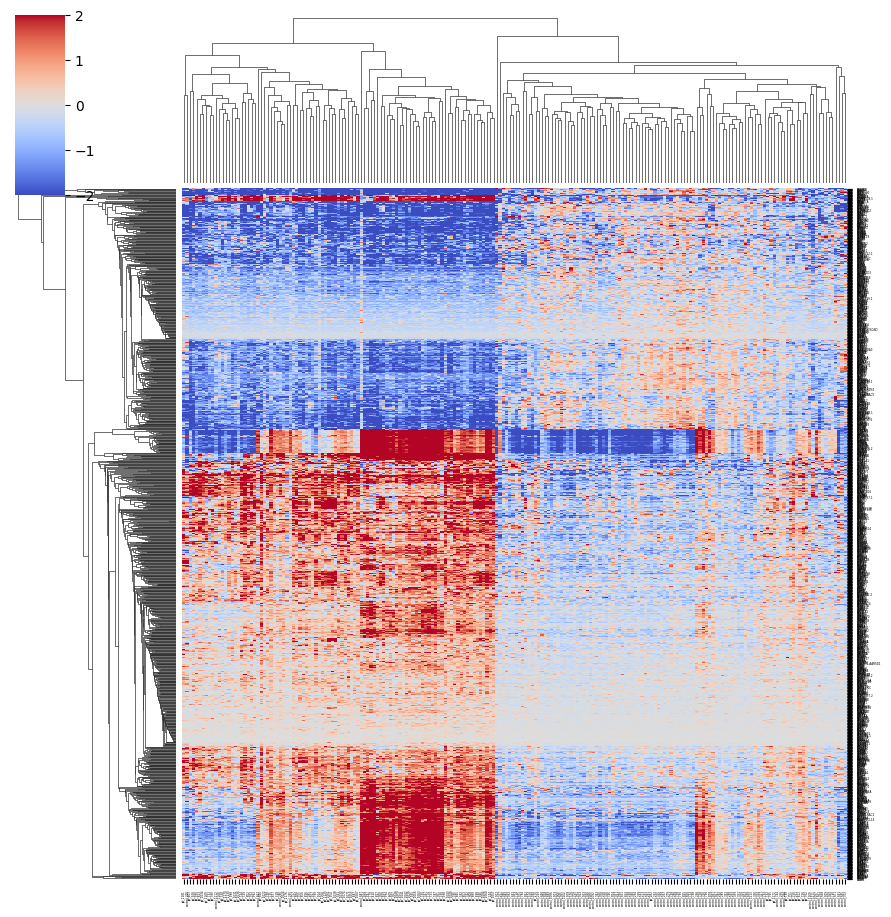

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


sns_plot = sns.clustermap(sig_data_log2fc, xticklabels=samples, yticklabels= sig_genes, cmap="coolwarm", vmin=-2, vmax=2)

# TODO - can this be done with easier syntax?
sns_plot.ax_heatmap.set_xticklabels(sns_plot.ax_heatmap.get_xmajorticklabels(), fontsize=2)
sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_ymajorticklabels(), fontsize=2)


sns_plot.savefig("plots/heatmap.pdf")

plt.show()

# sig_data_log2fc